
# Defining functions

In [1]:
import pickle
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot
from matplotlib import colors

### Loading probabilities

In [96]:
def pickle_dump(input_file, path):
    with open(path, "wb") as fp:
        dumped_file = pickle.dump(input_file, fp)
    return dumped_file

In [2]:
def pickle_load(path):
    with open(path, "rb") as fp:
        loaded_file = pickle.load(fp)
    return loaded_file

In [3]:
def get_logprob(probs):
    logprobs = []
    for stc_idx, stc in enumerate(probs):
        logprobs.append(np.log(stc))
    return logprobs

In [4]:
def per_stc_gram_probs(loaded_gram_probs):
    stc_gram_probs = np.array([loaded_gram_probs[x:x+36] for x in range(0,len(loaded_gram_probs),36)])
    return stc_gram_probs

In [5]:
def per_stc_ungram_probs(loaded_ungram_probs):
    stc_ungram_probs = np.array([loaded_ungram_probs[x:x+108] for x in range(0,len(loaded_ungram_probs),108)])
    return stc_ungram_probs

In [6]:
def get_case_violations(stc_ungrams):
    case_violations = np.array([[stc_ungrams[stc][x:x+36] for x in range(0, len(stc_ungrams[stc]),36)] for stc in range(len(stc_ungrams))])
    return case_violations



In [31]:
def check_lengths(loaded_grams, loaded_ungrams, stc_gram_probs, stc_ungram_probs, case_violations, stc_number):
    assert len(loaded_grams) == 1800
    assert len(loaded_ungrams) == 5400
    assert len(stc_gram_probs) == stc_number
    assert len(stc_gram_probs[0]) == 36
    assert len(stc_ungram_probs) == stc_number 
    assert len(stc_ungram_probs[0]) == 108
    assert len(case_violations) == stc_number 
    assert len(case_violations[0]) == 3 
    assert len(case_violations[0][0])  == 36

### Visualizing distributions of log probabilities

In [78]:
def get_upper_bound(gram_probs, ungram_probs):
    return (int(max(max(np.log(gram_probs)), max(np.log(ungram_probs))))+5)

def get_lower_bound(gram_probs, ungram_probs):
    return (int(min(min(np.log(gram_probs)), min(np.log(ungram_probs))))-5)

In [8]:
def all_cases_distribution(stc_gram_probs, case_violations, number_sentences, upper_bound, lower_bound, bins_number):
    
    all_grammatical = []
    all_ungrammatical = []
    
    for stc in range(number_sentences):
        for idx in range(36):
            all_grammatical.append(np.log(stc_gram_probs[stc][idx]))

        for case_violation in range(3):
            for idx in range(36):
                all_ungrammatical.append(np.log(case_violations[stc][case_violation][idx]))

    bins = np.linspace(lower_bound, upper_bound, bins_number)

    pyplot.hist(all_ungrammatical, bins, alpha=0.5, color="orange", label='ungrammatical sentences')
    pyplot.hist(all_grammatical, bins, alpha=0.5, color="blue", label='grammatical sentences')

    pyplot.legend(loc='upper right', prop={'size': 9})
    pyplot.xlabel("Log probabilities predicted by LSTM", fontsize = 12, fontname = "Times")
    pyplot.ylabel("Sentences", fontsize = 12, fontname = "Times")
    #pyplot.title("Distribution of log probabilities")
    pyplot.show()

In [9]:
def per_case_distribution(stc_gram_probs, case_violations, number_sentences, case, upper_bound, lower_bound, bins_number):
    
    """
    Possible cases are "nominative", "accusative" and "dative".
    """
    
    if case == "nominative":
        case_idx = 0
    elif case == "accusative":
        case_idx = 1
    elif case == "dative":
        case_idx = 2
    
    grammatical = []
    ungrammatical = []
    for stc in range(number_sentences):
        for idx in range(36):
            grammatical.append(np.log(stc_gram_probs[stc][idx]))
            ungrammatical.append(np.log(case_violations[stc][case_idx][idx]))

    bins = np.linspace(lower_bound, upper_bound, bins_number)

    pyplot.hist(grammatical, bins, alpha=0.5, color="blue", label='grammatical logprobs')
    pyplot.hist(ungrammatical, bins, alpha=0.5, color="orange", label='ungrammatical logprobs')

    pyplot.legend(loc='upper right')
    pyplot.title(f"Log probabilities for {case} violation")
    pyplot.show()

### Relative test

In [10]:
def relative_test(stc_gram_probs, case_violations, number_templates):

    stc_gram_sums = []
    for stc_idx in range(number_templates):
        tmp_sum = sum(stc_gram_probs[stc_idx])
        stc_gram_sums.append(tmp_sum)

    case_violations_sums = [[] for _ in range(number_templates)]
    for stc_idx in range(number_templates):
        for case_violation_idx in range(3):
            tmp_sum = sum(case_violations[stc_idx][case_violation_idx])
            case_violations_sums[stc_idx].append(tmp_sum)

    indicators = [[] for _ in range(number_templates)]
    for stc_idx in range(number_templates):
        for case_violation_idx in range(3):
            tmp_diff = stc_gram_sums[stc_idx] - case_violations_sums[stc_idx][case_violation_idx]
            if tmp_diff > 0:
                tmp_indicator = 1
            elif tmp_diff == 0:
                tmp_indicator = 0.5
            else:
                tmp_indicator = 0
            indicators[stc_idx].append(tmp_indicator)

    accuracy_nom_violation, accuracy_acc_violation, accuracy_dat_violation = 0, 0, 0
    for stc_idx in range(len(indicators)):
        accuracy_nom_violation += indicators[stc_idx][0]
        accuracy_acc_violation += indicators[stc_idx][1]
        accuracy_dat_violation += indicators[stc_idx][2]
        
    accuracy_nom_violation = accuracy_nom_violation / number_templates
    accuracy_acc_violation = accuracy_acc_violation / number_templates
    accuracy_dat_violation = accuracy_dat_violation / number_templates
    
    print("Accuracies: \n")
    print("Nominative violation:", accuracy_nom_violation)
    print("Accusative violation:", accuracy_acc_violation)
    print("Dative violation:", accuracy_dat_violation)

In [ ]:
# relative test : better code
score = 0
for template in range(50):
    G = 0
    U = 0
    indicator = 0
    for stc in range(36):
        G += stc_masc_gram_probs[template][stc]
        U += cases[template][2][stc]
    indicator = G - U
    if indicator > 0:
        score += 1
    else:
        continue
score /= 50
print(score)

### Compute ROC-AUC

In [11]:
def get_ROC_labels(number_sentences):
    
    labels = []
    
    for i in range(36*number_sentences):
        labels.append(1)
    for i in range(36*number_sentences):
        labels.append(0)
        
    return labels

In [12]:
def get_ROC_all_labels(number_sentences):
    
    labels = []
    
    for i in range(36*number_sentences):
        labels.append(1)
    for i in range(108*number_sentences):
        labels.append(0)
        
    return labels

In [13]:
def group_sentences(case, stc_gram_probs, case_violations, number_sentences):
    
    """
    Group sentence probabilies according to case violation.
    Possible cases are "nominative", "accusative" and "dative".
    """
    
    if case == "nominative":
        case_idx = 0
    elif case == "accusative":
        case_idx = 1
    elif case == "dative":
        case_idx = 2
        
    probs = []

    for idx in range(number_sentences):
        # append all grammatical probs
        for stc in range(36):
            probs.append(stc_gram_probs[idx][stc])

    for idx in range(number_sentences):
        # append all ungrammatical probs for desired case violation
        for stc in range(36):
            probs.append(case_violations[idx][case_idx][stc])
    
    return probs

In [14]:
def group_all_sentences(gram_probs, ungram_probs, ):
    
    """
    """
    
    all_sentences = []
    for stc_idx, stc in enumerate(gram_probs):
        all_sentences.append(stc)
    for stc_idx, stc in enumerate(ungram_probs):
        all_sentences.append(stc)
        
    return all_sentences

In [116]:
def get_ROC(case, case_probs, labels):
    
    """
    Possible cases are "nominative", "accusative" and "dative".
    """
    
    # calculate AUC
    auc = roc_auc_score(labels, case_probs)
    print('AUC: %.3f' % auc)
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(labels, case_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='')
    
    # write the title
    pyplot.title(f"{case} case violation")
    
    # show the plot
    pyplot.show()

In [117]:
def get_ROC_all(case_probs, labels):
    
    
    # calculate AUC
    auc = roc_auc_score(labels, case_probs)
    print('AUC: %.3f' % auc)
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(labels, case_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    
    # label axes
    pyplot.xlabel("False positive rate", fontsize = 12, fontname = "Times")
    pyplot.ylabel("True positive rate", fontsize = 12, fontname = "Times")
    
    pyplot.text(0.1, 0.9, f'AUC = {round(auc,2)}', horizontalalignment='left', verticalalignment='top', 
                    fontname="Times", fontsize = 12)
    #write the title
    pyplot.title("Grammatical sentences vs all ungrammatical sentences")
    
    # show the plot
    pyplot.show()

### Get normalized results

In [17]:
def get_normalized_probabilities(ngrams_logprobs, LSTM_logprobs):
    
    """
    Normalize sentence probabilities calculated by LSTM by sentence probabilities calculated from ngram models.
    """
    
    normalized_probs = []
    
    for stc in range(len(LSTM_logprobs)):
        normalized_prob = np.log(LSTM_logprobs[stc]) - np.log(ngrams_logprobs[stc])
        normalized_prob = np.exp(normalized_prob)
        normalized_probs.append(normalized_prob)
    
    return normalized_probs

In [18]:
def test_normalized(ngram_probs, LSTM_probs):
    
    normalized_probs = []
    for stc in range(len(LSTM_probs)):
        normalized_prob = LSTM_probs[stc]/ngram_probs[stc]
        normalized_probs.append(normalized_prob)
    
    return normalized_probs

In [158]:
def correlation_matrix(x_distribution, y_distribution):
    
    matplotlib.style.use('ggplot')
    pyplot.scatter(x_distribution, y_distribution)
    pyplot.show()

In [161]:
def get_correlation(path_first_distribution, path_second_distribution):
    
    first_distribution = np.log(pickle_load(path_first_distribution))
    second_distribution = np.log(pickle_load(path_second_distribution))
    correlation_matrix(first_distribution, second_distribution)

In [91]:
def get_results(grammatical_path, ungrammatical_path):
     
    # gram is for grammatical, ungram for ungrammatical 
    
    template_number = 50

    gram_probabilities = pickle_load(grammatical_path)
    ungram_probabilities = pickle_load(ungrammatical_path)
    gram_sentence_probabilities = per_stc_gram_probs(gram_probabilities)
    ungram_sentence_probabilities = per_stc_ungram_probs(ungram_probabilities)
    case_duplications = get_case_violations(ungram_sentence_probabilities)
    
    check_lengths(gram_probabilities, ungram_probabilities, gram_sentence_probabilities,
                  ungram_sentence_probabilities, case_duplications, template_number)
    
    upper_logprob = get_upper_bound(gram_probabilities, ungram_probabilities)
    lower_logprob = get_lower_bound(gram_probabilities, ungram_probabilities)
    all_cases_distribution(gram_sentence_probabilities, case_duplications, template_number, 
                           upper_logprob, lower_logprob, 55)
    per_case_distribution(gram_sentence_probabilities, case_duplications, template_number, "nominative", 
                          upper_logprob, lower_logprob, 35)
    per_case_distribution(gram_sentence_probabilities, case_duplications, template_number, "accusative", 
                          upper_logprob, lower_logprob, 35)
    per_case_distribution(gram_sentence_probabilities, case_duplications, template_number, "dative", 
                          upper_logprob, lower_logprob, 35)
    
    # Summing score
    relative_test(gram_sentence_probabilities, case_duplications, template_number)
    
    # AUC-ROC
    ROC_labels = get_ROC_labels(template_number)
    nom_probs = group_sentences("nominative",gram_sentence_probabilities, case_duplications, template_number)
    acc_probs = group_sentences("accusative",gram_sentence_probabilities, case_duplications, template_number)
    dat_probs = group_sentences("dative",gram_sentence_probabilities, case_duplications, template_number)
    
    get_ROC("nominative", nom_probs, ROC_labels)
    get_ROC("accusative", acc_probs, ROC_labels)
    get_ROC("dative", dat_probs, ROC_labels)
    
    all_sentences = group_all_sentences(gram_probabilities, ungram_probabilities)
    all_labels = get_ROC_all_labels(template_number)
    get_ROC_all(all_sentences, all_labels)

# Results

## First LSTM model

### Masc dataset

In [147]:
# Set paths to probabilities

path_LSTM_grammatical = "results/LSTM_results/LSTM_gram_probs.txt"
path_LSTM_ungrammatical = "results/LSTM_results/LSTM_ungram_probs.txt"
path_unigram_grammatical = "results/ngrams_results/unigrams_gram_probs.txt"
path_unigram_ungrammatical = "results/ngrams_results/unigrams_ungram_probs.txt"
path_bigram_grammatical = "results/ngrams_results/bigrams_gram_probs.txt"
path_bigram_ungrammatical = "results/ngrams_results/bigrams_ungram_probs.txt"
path_unigram_normalized_grammatical = "results/normalized_results/unigram_normalized_gram_probs"
path_unigram_normalized_ungrammatical = "results/normalized_results/unigram_normalized_ungram_probs"
path_bigram_normalized_grammatical = "results/normalized_results/bigram_normalized_gram_probs"
path_bigram_normalized_ungrammatical = "results/normalized_results/bigram_normalized_ungram_probs"

path_most_meaningful_LSTM_grammatical = "results/LSTM_results/LSTM_most_meaningful_gram_probs.txt"
path_most_meaningful_unigram_grammatical = "results/ngrams_results/unigram_most_meaningful_gram_probs.txt"
path_most_meaningful_bigram_grammatical = "results/ngrams_results/bigram_most_meaningful_gram_probs.txt"

In [107]:
# Generate normalized results

def compute_ngram_normalized_results(path_ngram_gram, path_ngram_ungram, path_LSTM_gram, path_LSTM_ungram, ngram):

    grammatical_probs = pickle_load(path_LSTM_gram)
    ungrammatical_probs = pickle_load(path_LSTM_ungram)
    ngram_grammatical_probs = pickle_load(path_ngram_gram)
    ngram_ungrammatical_probs = pickle_load(path_ngram_ungram)
    ngram_normalized_grammatical_probs = get_normalized_probabilities(ngram_grammatical_probs, 
                                                            grammatical_probs)
    ngram_normalized_ungrammatical_probs = get_normalized_probabilities(ngram_ungrammatical_probs, 
                                                             ungrammatical_probs)
    pickle_dump(ngram_normalized_grammatical_probs, 
                "results/normalized_results/" + ngram + "_normalized_gram_probs")
    pickle_dump(ngram_normalized_ungrammatical_probs, 
                "results/normalized_results/" + ngram + "_normalized_ungram_probs")    

In [108]:
compute_ngram_normalized_results(path_unigrams_grammatical, path_unigrams_ungrammatical, path_LSTM_grammatical, 
                             path_LSTM_ungrammatical, "unigram")
compute_ngram_normalized_results(path_bigrams_grammatical, path_bigrams_ungrammatical, path_LSTM_grammatical, 
                             path_LSTM_ungrammatical, "bigram")

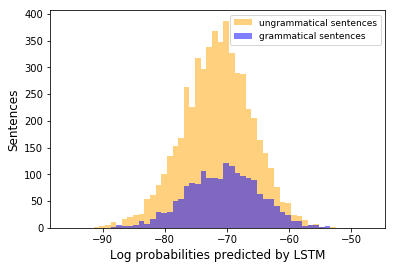

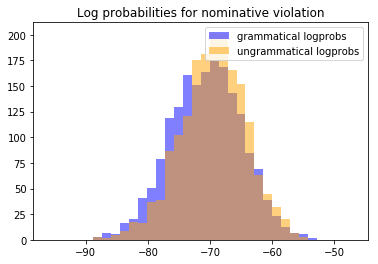

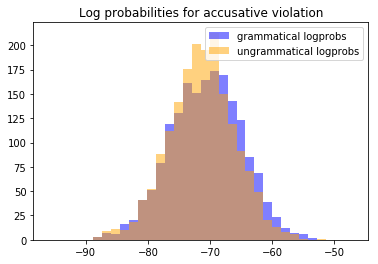

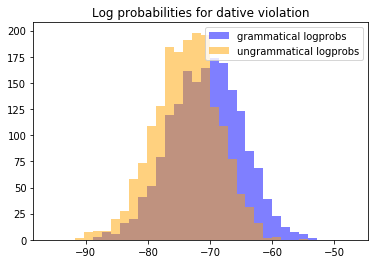

Accuracies: 

Nominative violation: 0.6
Accusative violation: 0.8
Dative violation: 1.0
AUC: 0.440


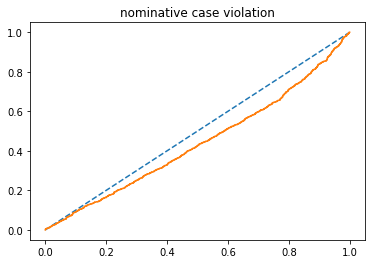

AUC: 0.535


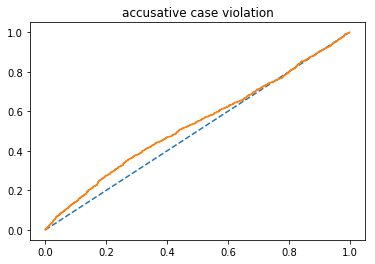

AUC: 0.658


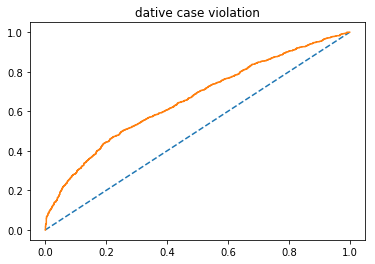

AUC: 0.545


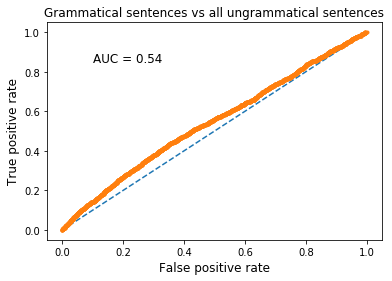

In [118]:
get_results(path_LSTM_grammatical, path_LSTM_ungrammatical)

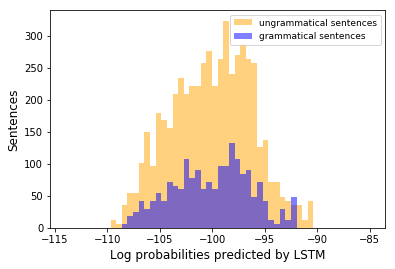

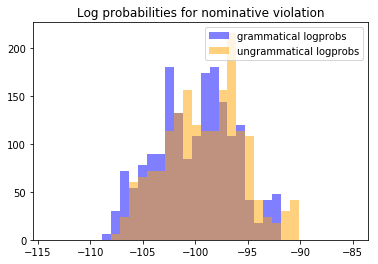

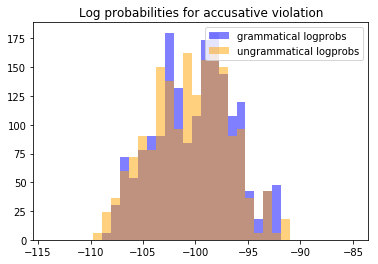

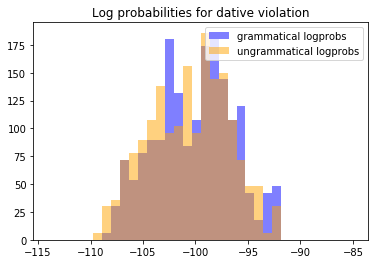

Accuracies: 

Nominative violation: 0.0
Accusative violation: 1.0
Dative violation: 0.98
AUC: 0.426


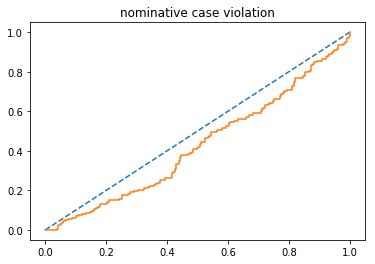

AUC: 0.535


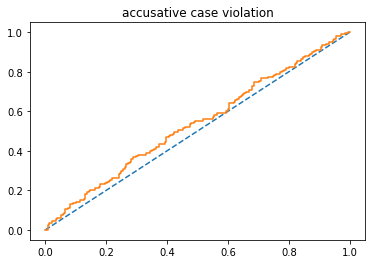

AUC: 0.538


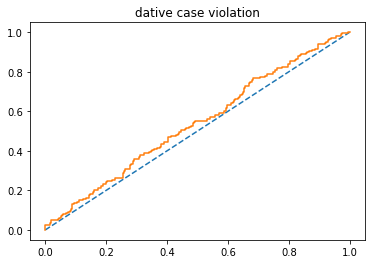

AUC: 0.500


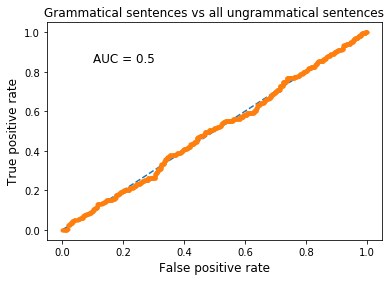

In [148]:
get_results(path_unigram_grammatical, path_unigram_ungrammatical)

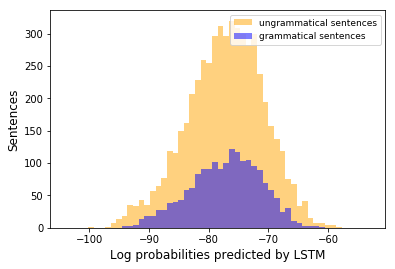

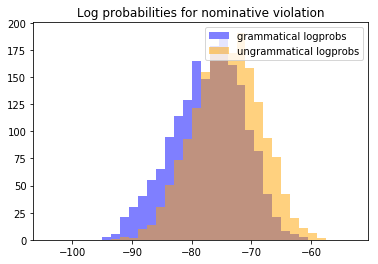

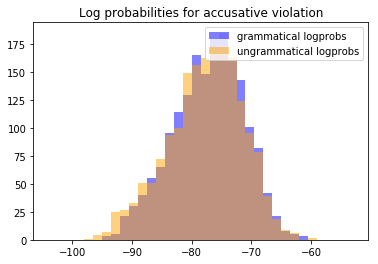

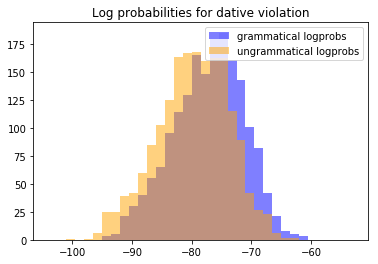

Accuracies: 

Nominative violation: 0.0
Accusative violation: 0.38
Dative violation: 1.0
AUC: 0.360


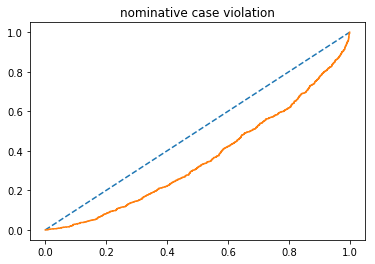

AUC: 0.521


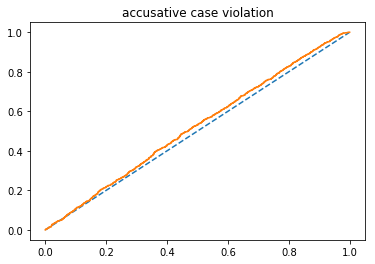

AUC: 0.616


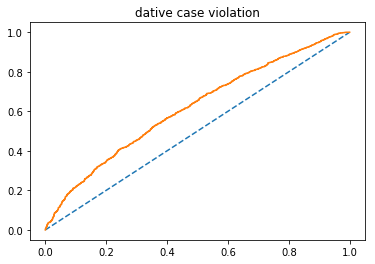

AUC: 0.499


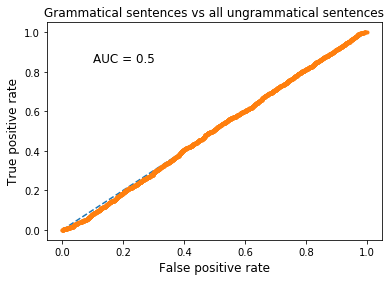

In [149]:
get_results(path_bigram_grammatical, path_bigram_ungrammatical)

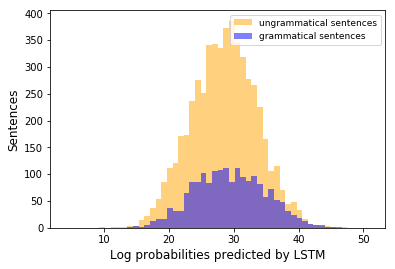

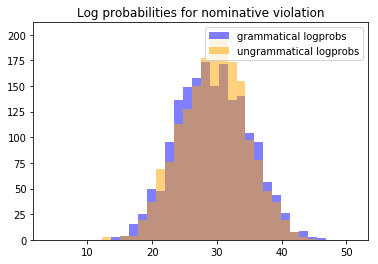

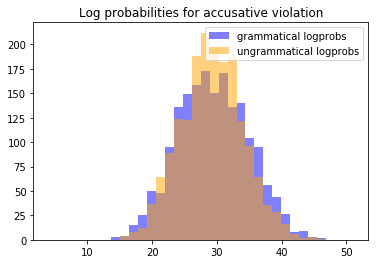

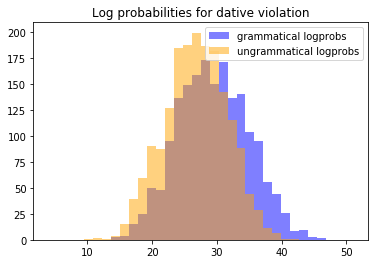

Accuracies: 

Nominative violation: 0.9
Accusative violation: 0.88
Dative violation: 1.0
AUC: 0.489


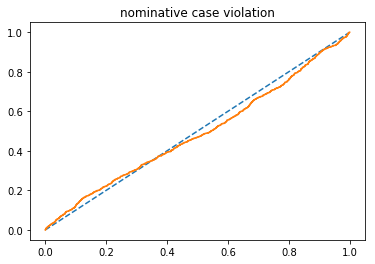

AUC: 0.509


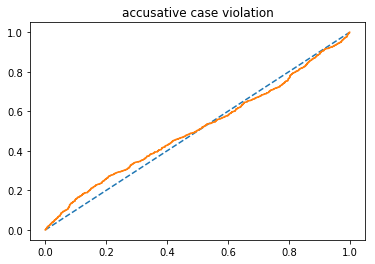

AUC: 0.635


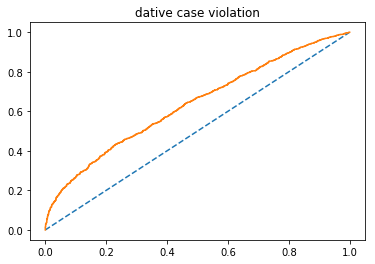

AUC: 0.544


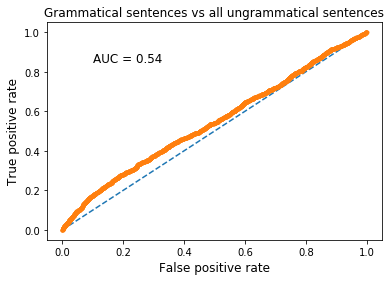

In [120]:
get_results(path_unigram_normalized_grammatical, path_unigram_ungrammatical)

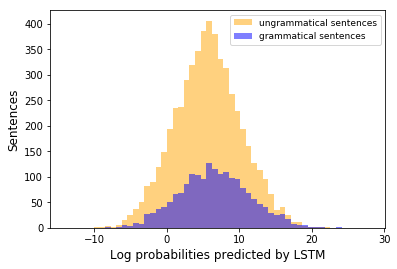

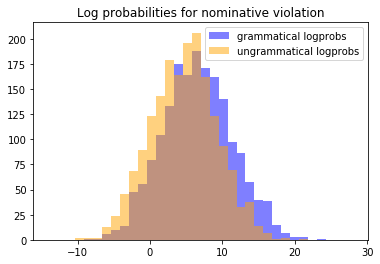

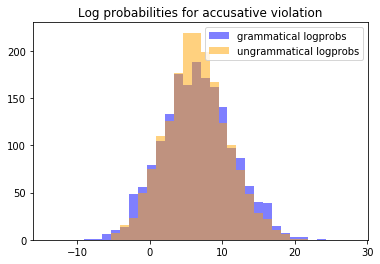

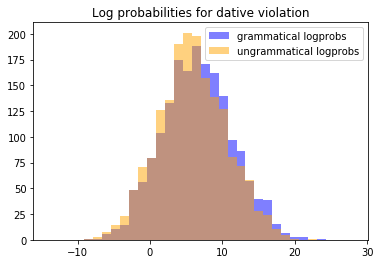

Accuracies: 

Nominative violation: 0.9
Accusative violation: 0.92
Dative violation: 0.86
AUC: 0.610


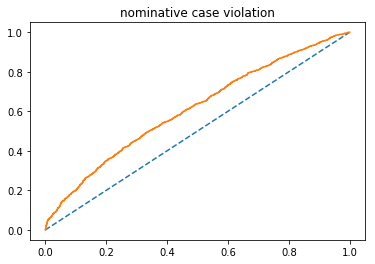

AUC: 0.508


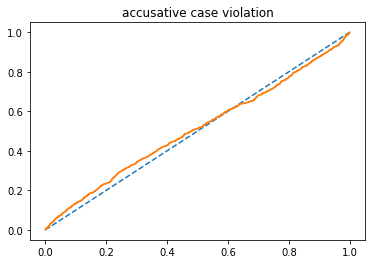

AUC: 0.540


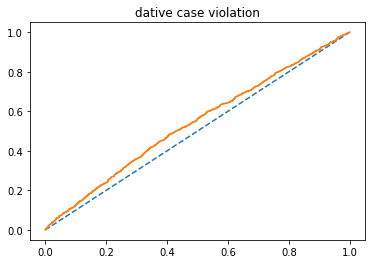

AUC: 0.553


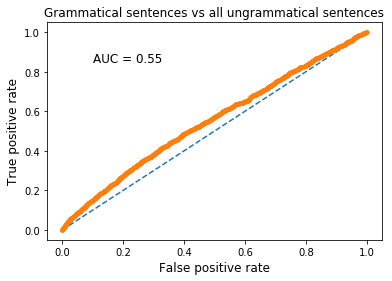

In [121]:
get_results(path_bigram_normalized_grammatical, path_bigram_ungrammatical)

## Results on most semantically plausible sentences

In [143]:
def get_most_meaningful_probabilities(grammatical_path, model):
    
    sentence_number = 50
    most_meaningful = [[] for _ in range(sentence_number)]
    
    gram_probabilities = pickle_load(grammatical_path)
    gram_sentence_probabilities = per_stc_gram_probs(gram_probabilities)
    
    for stc_idx, stc in enumerate(gram_sentence_probabilities):
        for idx in range(6,12):
            most_meaningful[stc_idx].append(stc[idx])
    
    if model == "LSTM":
        RESULTS_PATH = "results/LSTM_results/"
    else:
        RESULTS_PATH = "results/ngrams_results/"
            
    pickle_dump(most_meaningful, RESULTS_PATH + model + "_most_meaningful_gram_probs.txt")

In [144]:
def get_least_meaningful_probabilities(grammatical_path, model):
    
    sentence_number = 50
    least_meaningful = [[] for _ in range(sentence_number)]
    
    gram_probabilities = pickle_load(grammatical_path)
    gram_sentence_probabilities = per_stc_gram_probs(gram_probabilities)
            
    for stc_idx, stc in enumerate(gram_sentence_probabilities):
        for idx in range(0,6):
            least_meaningful[stc_idx].append(stc[idx])
        for idx in range(12,36):
            least_meaningful[stc_idx].append(stc[idx])
    
    if model == "LSTM":
        RESULTS_PATH = "results/LSTM_results/"
    else:
        RESULTS_PATH = "results/ngrams_results/"
    pickle_dump(least_meaningful, RESULTS_PATH + model + "_least_meaningful_gram_probs.txt")

In [150]:
# generate most and least semantically plausibility sentence probabilities
get_most_meaningful_probabilities(path_LSTM_grammatical, "LSTM")
get_most_meaningful_probabilities(path_unigram_grammatical, "unigram")
get_most_meaningful_probabilities(path_bigram_grammatical, "bigram")

In [130]:
def get_ROC_unbalanced_labels(number_templates):
    
    labels = []
    
    for i in range(6*number_templates):
        labels.append(1)
    for i in range(36*number_templates):
        labels.append(0)
        
    return labels

In [137]:
def group_unbalanced_sentences(case, stc_gram_probs, case_violations, number_templates):
    
    """
    Group sentence probabilies according to case violation.
    Possible cases are "nominative", "accusative" and "dative".
    """
    
    if case == "nominative":
        case_idx = 0
    elif case == "accusative":
        case_idx = 1
    elif case == "dative":
        case_idx = 2
        
    probs = []

    for idx in range(number_templates):
        # append all grammatical probabilities
        for stc in range(6):
            probs.append(stc_gram_probs[idx][stc])

    for idx in range(number_templates):
        # append all ungrammatical probabilitiess for desired case violation
        for stc in range(36):
            probs.append(case_violations[idx][case_idx][stc])
    
    return probs

In [136]:
def get_ROC_unbalanced_all_labels(number_sentences):
    
    labels = []
    
    for i in range(6*number_sentences):
        labels.append(1)
    for i in range(108*number_sentences):
        labels.append(0)
        
    return labels

In [138]:
def get_semantically_plausible_results(most_meaningful_grammatical_path, ungrammatical_path):
     
    # gram is for grammatical, ungram for ungrammatical 
    
    template_number = 50

    gram_sentence_probabilities = pickle_load(most_meaningful_grammatical_path)
    ungram_probabilities = pickle_load(ungrammatical_path)
    ungram_sentence_probabilities = per_stc_ungram_probs(ungram_probabilities)
    case_duplications = get_case_violations(ungram_sentence_probabilities)

    # AUC-ROC
    ROC_labels = get_ROC_unbalanced_labels(template_number)
    nom_probs = group_unbalanced_sentences("nominative",gram_sentence_probabilities, 
                                           case_duplications, template_number)
    acc_probs = group_unbalanced_sentences("accusative",gram_sentence_probabilities, 
                                           case_duplications, template_number)
    dat_probs = group_unbalanced_sentences("dative",gram_sentence_probabilities, 
                                           case_duplications, template_number)
    
    get_ROC("nominative", nom_probs, ROC_labels)
    get_ROC("accusative", acc_probs, ROC_labels)
    get_ROC("dative", dat_probs, ROC_labels)
    
    all_gram_probs = []
    for idx in range(template_number):
        for stc_idx, stc in enumerate(gram_sentence_probabilities[idx]):
            all_gram_probs.append(stc)
        
    all_sentences = group_all_sentences(all_gram_probs, ungram_probabilities)
    all_labels = get_ROC_unbalanced_all_labels(template_number)
    get_ROC_all(all_sentences, all_labels)

AUC: 0.523


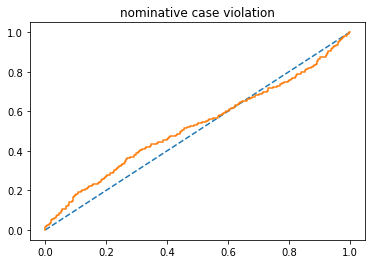

AUC: 0.610


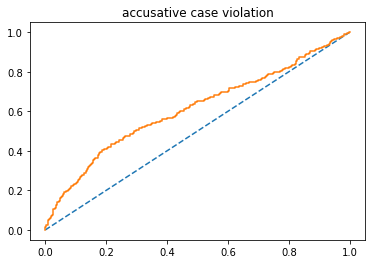

AUC: 0.719


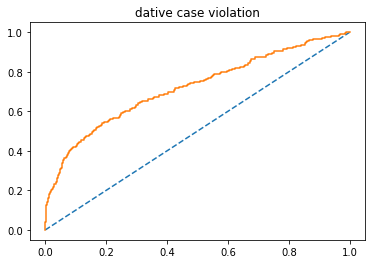

AUC: 0.617


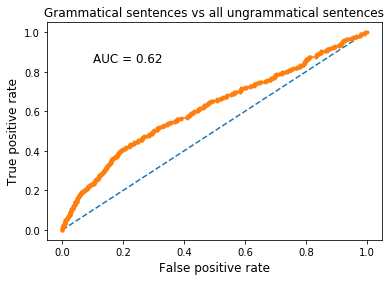

In [139]:
get_semantically_plausible_results(path_most_meaningful_LSTM_grammatical, path_LSTM_ungrammatical)

AUC: 0.439


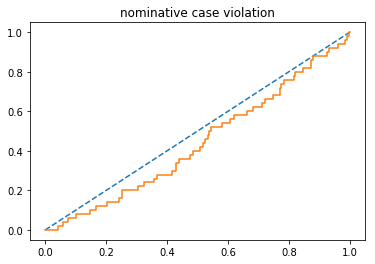

AUC: 0.549


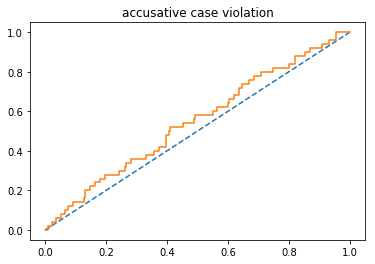

AUC: 0.551


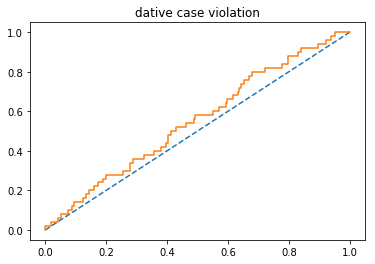

AUC: 0.513


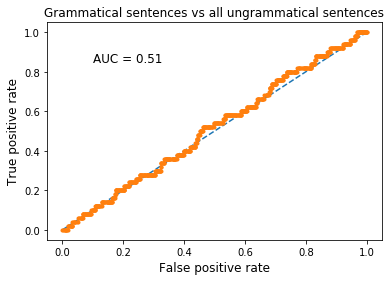

In [153]:
get_semantically_plausible_results(path_most_meaningful_unigram_grammatical, path_unigram_ungrammatical)

AUC: 0.414


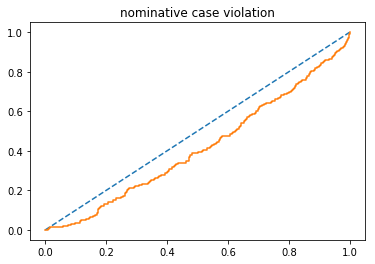

AUC: 0.576


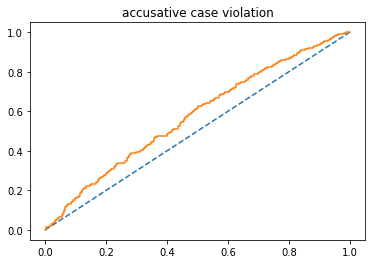

AUC: 0.668


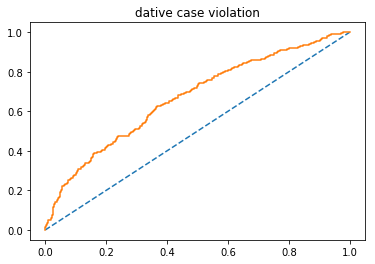

AUC: 0.553


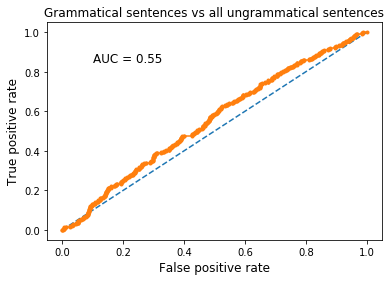

In [154]:
get_semantically_plausible_results(path_most_meaningful_bigram_grammatical, path_bigram_ungrammatical)

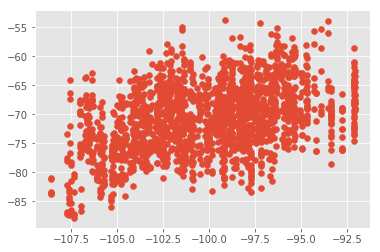

In [159]:
get_correlation(path_unigram_grammatical, path_LSTM_grammatical)

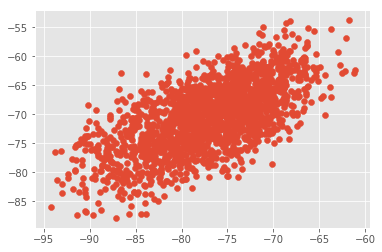

In [160]:
get_correlation(path_bigram_grammatical, path_LSTM_grammatical)